This notebook demonstrates how one can apply Optimal Transporting for defining similarity between sentences.

Dataset source: https://wiki.cimec.unitn.it/tiki-index.php?page=CLIC#datasets \
Tutorial used: https://remi.flamary.com/cours/tuto_otml.html

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine

import gensim.downloader as api
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import download

from src.sinkhorn import sinkhorn_knopp, sinkhorn_stabilized
from src.da import SinkhornTransport
from visualisation.transport_plan_visualisation import plot_text_transportation

# Transportation plan for similar news headlines

In [3]:
model = api.load('word2vec-google-news-300')
download('stopwords')  
stop_words = stopwords.words('english')

In [4]:
def preprocess(sentence):
    tokens = word_tokenize(sentence.lower())
    return [w for w in tokens if w not in stop_words and w.isalpha()]

In [5]:
def sinkhorn_stabilized_dist(sent1, sent2, params):
    sp_transp = SinkhornTransport(sinkhorn_stabilized,
                                  params, metric='sqeuclidean')
    d1, d2 = np.ones(sent1.shape[0]), np.ones(sent2.shape[0])
    d1 /= sent1.shape[0]
    d2 /= sent2.shape[0]
        
    sp_transp.fit(sent1, sent2,
                  distr_xs=d1, distr_xt=d2)
    dist = (sp_transp.ot_matrix * sp_transp._C).sum() / sp_transp.ot_matrix.sum()
    
    return dist, sp_transp

In [6]:
s1 = 'FDA advisers recommend authorization of Pfizer virus vaccine'
s2 = 'FDA panel recommends approval of Pfizer’s coronavirus vaccine'


s1_vec = np.array([model.get_vector(w) for w in preprocess(s1)])
s2_vec = np.array([model.get_vector(w) for w in preprocess(s2)])
d, st = sinkhorn_stabilized_dist(s1_vec, s2_vec,
                                 {'reg': 1e-2, 'max_iter': 1e2})

FDA advisers recommend authorization of Pfizer virus vaccine
FDA panel recommends approval of Pfizer’s coronavirus vaccine
Distance: 6.65474765465277


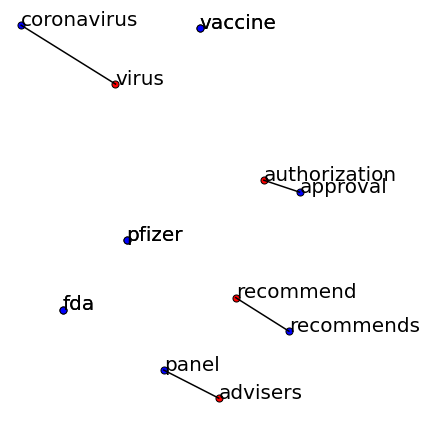

In [19]:
print(f'{s1}\n{s2}\nDistance: {d}')

plot_text_transportation(preprocess(s1), preprocess(s2),
                         s1_vec, s2_vec,
                         st.ot_matrix)

# SICK (Sentences Involving Compositional Knowledge) dataset

In [20]:
sents = pd.read_csv('texts/SICK_annotated.txt',
                    sep='\t')
sents[['sentence_A', 'sentence_B', 'relatedness_score']].head()

,sentence_A,sentence_B,relatedness_score
0,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5
1,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2
2,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7
3,The young boys are playing outdoors and the ma...,There is no boy playing outdoors and there is ...,3.6
4,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4


In [21]:
As = sents['sentence_A'].values
Bs = sents['sentence_B'].values
scores = sents['relatedness_score']

In [22]:
print(f'{As[1]}\n{Bs[1]}\nRelatedness score: {scores[1]}')

A group of children is playing in the house and there is no man standing in the background
A group of kids is playing in a yard and an old man is standing in the background
Relatedness score: 3.2


In [23]:
a0_vec = np.array([model.get_vector(w) for w in preprocess(As[1])])
b0_vec = np.array([model.get_vector(w) for w in preprocess(Bs[1])])
d, st = sinkhorn_stabilized_dist(a0_vec, b0_vec,
                                 {'reg': 1e-2, 'max_iter': 1e2})

In [24]:
print(f'{As[1]}\n{Bs[1]}\nComputed distance: {d}')

A group of children is playing in the house and there is no man standing in the background
A group of kids is playing in a yard and an old man is standing in the background
Computed distance: 2.1564783250082007


In [28]:
transp_costs = []
cosine_dist = []
emd_cost = []
for i in range(As.shape[0]):
    
    s1 = np.array([model.get_vector(w) for w in preprocess(As[i]) if w in model.vocab.keys()])
    s2 = np.array([model.get_vector(w) for w in preprocess(Bs[i]) if w in model.vocab.keys()])
    
    d, t = sinkhorn_stabilized_dist(s1, s2,
                         {'reg': 1e-2, 'max_iter': 1e2})
    
    transp_costs.append(d)
    cosine_dist.append(cosine(s1.mean(axis=0), s2.mean(axis=0)))
    emd_cost.append(model.wmdistance(preprocess(As[i]), preprocess(Bs[i])))

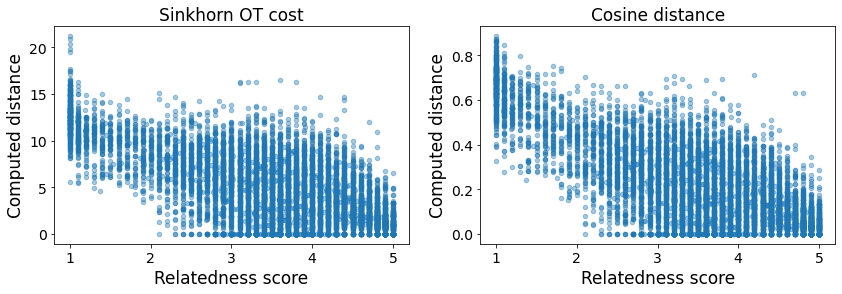

In [31]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].scatter(scores, transp_costs,
              alpha=.4, s=20)
ax[0].set_xlabel('Relatedness score', fontsize=17)
ax[0].set_ylabel('Computed distance', fontsize=17)
ax[0].tick_params(labelsize=14)
ax[0].set_title('Sinkhorn OT cost', fontsize=17)
ax[1].scatter(scores, cosine_dist,
              alpha=.4, s=20)
ax[1].set_xlabel('Relatedness score', fontsize=17)
ax[1].set_ylabel('Computed distance', fontsize=17)
ax[1].tick_params(labelsize=14)
_ = ax[1].set_title('Cosine distance', fontsize=17)

In [37]:
print('Pearson correlation coefficient:\n'
      f'\tSinkhorn OT cost: {pearsonr(scores, transp_costs)[0]:.3f}\n'
      f'\tWord Mover\'s Distance (gensim built-in): {pearsonr(scores, emd_cost)[0]:.3f}\n'
      f'\tCosine distance: {pearsonr(scores, cosine_dist)[0]:.3f}')

Pearson correlation coefficient:
	Sinkhorn OT cost: -0.654
	Word Mover's Distance (gensim built-in): -0.634
	Cosine distance: -0.715


According to Pearson's correlation coefficient, cosine distance works better for these data. However, our implementation of Optimal Transporting has the same performance as the built-in version in gensim (based on EMD optimal transporting algorithm).